# Converting TXT Annotations to XML Format

This notebook converts license plate annotations from the `Data` folder (which uses TXT format) to the XML format used in `Dataset_XML`. 

This conversion will maintain consistency across all datasets and allow them to be combined into a single unified dataset.

## Annotation Format Differences

### TXT Format (Data folder)
- Uses `(x, y, w, h)` format
- Where (x,y) is the top-left corner and w,h are dimensions
- Example: `AYO9034.jpg 528 412 162 52 AYO9034`
  1. Filename
  2. x-coordinate (top-left corner)
  3. y-coordinate (top-left corner)
  4. width
  5. height
  6. License plate text

### XML Format (Dataset_XML)
- Uses `(xmin, ymin, xmax, ymax)` coordinates
- Defines the top-left and bottom-right corners of the box
- Full XML structure with additional metadata

In [1]:
import os
import shutil
import glob
import xml.etree.ElementTree as ET
from xml.dom import minidom
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm
from pathlib import Path

In [2]:
# Set up paths
base_dir = r"c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection"
source_dir = os.path.join(base_dir, "Data", "Total")
output_dir = os.path.join(base_dir, "Dataset_XML")
output_images_dir = os.path.join(output_dir, "images")
output_anno_dir = os.path.join(output_dir, "annotations")

# Make sure output directories exist
os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_anno_dir, exist_ok=True)

print(f"Source directory: {source_dir}")
print(f"Output directory: {output_dir}")
print(f"Output images: {output_images_dir}")
print(f"Output annotations: {output_anno_dir}")

Source directory: c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\Data\Total
Output directory: c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\Dataset_XML
Output images: c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\Dataset_XML\images
Output annotations: c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\Dataset_XML\annotations


In [3]:
def create_xml_annotation(img_path, txt_path, output_xml_path, prefix="data_"):
    """
    Create XML annotation file from TXT annotation
    
    Args:
        img_path (str): Path to the image file
        txt_path (str): Path to the TXT annotation file
        output_xml_path (str): Path to save XML annotation
        prefix (str): Prefix to add to the filename in XML
        
    Returns:
        bool: Success status
    """
    try:
        # Read image to get dimensions
        img = cv2.imread(img_path)
        if img is None:
            print(f"Could not read image: {img_path}")
            return False
        
        height, width, depth = img.shape
        
        # Get the base filename
        img_filename = os.path.basename(img_path)
        prefixed_filename = f"{prefix}{img_filename}"
        
        # Read TXT annotation
        with open(txt_path, 'r') as f:
            txt_data = f.read().strip().split()
        
        # Parse TXT data
        # Format: filename x y width height license_text
        # Example: AYO9034.jpg 528 412 162 52 AYO9034
        
        if len(txt_data) < 5:
            print(f"Invalid TXT annotation format in {txt_path}: {txt_data}")
            return False
        
        # Some files might have the license text, others might not
        # The first field is the filename, then x, y, width, height
        x = int(txt_data[1])
        y = int(txt_data[2])
        w = int(txt_data[3])
        h = int(txt_data[4])
        
        # Calculate XML format (xmin, ymin, xmax, ymax)
        xmin = x
        ymin = y
        xmax = x + w
        ymax = y + h
        
        # License plate text (if available)
        license_text = txt_data[5] if len(txt_data) > 5 else ""
        
        # Create XML structure
        annotation = ET.Element('annotation')
        
        folder = ET.SubElement(annotation, 'folder')
        folder.text = 'images'
        
        filename = ET.SubElement(annotation, 'filename')
        filename.text = prefixed_filename
        
        path = ET.SubElement(annotation, 'path')
        path.text = os.path.join(output_images_dir, prefixed_filename)
        
        source = ET.SubElement(annotation, 'source')
        database = ET.SubElement(source, 'database')
        database.text = 'Unknown'
        
        size = ET.SubElement(annotation, 'size')
        width_elem = ET.SubElement(size, 'width')
        width_elem.text = str(width)
        height_elem = ET.SubElement(size, 'height')
        height_elem.text = str(height)
        depth_elem = ET.SubElement(size, 'depth')
        depth_elem.text = str(depth)
        
        segmented = ET.SubElement(annotation, 'segmented')
        segmented.text = '0'
        
        obj = ET.SubElement(annotation, 'object')
        
        name = ET.SubElement(obj, 'n')
        name.text = 'licence'
        
        pose = ET.SubElement(obj, 'pose')
        pose.text = 'Unspecified'
        
        truncated = ET.SubElement(obj, 'truncated')
        truncated.text = '0'
        
        difficult = ET.SubElement(obj, 'difficult')
        difficult.text = '0'
        
        if license_text:
            lp_text = ET.SubElement(obj, 'license_text')
            lp_text.text = license_text
        
        bndbox = ET.SubElement(obj, 'bndbox')
        
        xmin_elem = ET.SubElement(bndbox, 'xmin')
        xmin_elem.text = str(xmin)
        ymin_elem = ET.SubElement(bndbox, 'ymin')
        ymin_elem.text = str(ymin)
        xmax_elem = ET.SubElement(bndbox, 'xmax')
        xmax_elem.text = str(xmax)
        ymax_elem = ET.SubElement(bndbox, 'ymax')
        ymax_elem.text = str(ymax)
        
        # Convert to string and write to file
        tree = ET.ElementTree(annotation)
        tree.write(output_xml_path)
        
        return True
    
    except Exception as e:
        print(f"Error creating XML for {img_path}: {e}")
        return False

In [4]:
def process_txt_to_xml(source_dir, prefix="data_"):
    """
    Process all TXT annotations in source directory and convert to XML
    
    Args:
        source_dir (str): Directory containing images and TXT annotations
        prefix (str): Prefix to add to filenames
        
    Returns:
        int: Number of processed files
    """
    # Find all TXT files
    txt_files = glob.glob(os.path.join(source_dir, "*.txt"))
    print(f"Found {len(txt_files)} TXT annotation files")
    
    n_processed = 0
    n_skipped = 0
    
    for txt_path in tqdm(txt_files, desc=f"Converting to XML"):
        # Get corresponding image file
        img_base = os.path.splitext(os.path.basename(txt_path))[0]
        
        # Look for image with different possible extensions
        img_found = False
        for ext in [".jpg", ".jpeg", ".png"]:
            img_path = os.path.join(source_dir, f"{img_base}{ext}")
            if os.path.exists(img_path):
                img_found = True
                break
        
        if not img_found:
            print(f"  Skipping {txt_path} - no matching image")
            n_skipped += 1
            continue
        
        # Determine output paths
        img_filename = os.path.basename(img_path)
        target_img_file = f"{prefix}{img_filename}"
        target_anno_file = f"{prefix}{img_base}.xml"
        
        target_img_path = os.path.join(output_images_dir, target_img_file)
        target_anno_path = os.path.join(output_anno_dir, target_anno_file)
        
        # Copy image
        shutil.copy2(img_path, target_img_path)
        
        # Create XML annotation
        success = create_xml_annotation(img_path, txt_path, target_anno_path, prefix)
        
        if success:
            n_processed += 1
        else:
            n_skipped += 1
    
    return n_processed, n_skipped

# Process all files in the Data directory
n_processed, n_skipped = process_txt_to_xml(source_dir, prefix="data_")

print(f"\nProcessed {n_processed} files from Data directory")
print(f"Skipped {n_skipped} files due to errors or missing images")

Found 444 TXT annotation files


Converting to XML: 100%|██████████| 444/444 [00:12<00:00, 34.37it/s]


Processed 444 files from Data directory
Skipped 0 files due to errors or missing images


In [5]:
# Count total files in output directory
data_images = len([f for f in os.listdir(output_images_dir) if f.startswith('data_')])
data_annotations = len([f for f in os.listdir(output_anno_dir) if f.startswith('data_')])

v2_images = len([f for f in os.listdir(output_images_dir) if f.startswith('v2_')])
v3_images = len([f for f in os.listdir(output_images_dir) if f.startswith('v3_')])

print(f"\nData (original TXT format) converted to XML:")
print(f"  Images: {data_images}")
print(f"  Annotations: {data_annotations}")

print(f"\nExisting data in Dataset_XML:")
print(f"  DataV2 images: {v2_images}")
print(f"  DataV3 images: {v3_images}")

print(f"\nTotal Dataset_XML size:")
print(f"  Total images: {data_images + v2_images + v3_images}")
print(f"  Total annotations: {data_annotations + v2_images + v3_images}")


Data (original TXT format) converted to XML:
  Images: 444
  Annotations: 444

Existing data in Dataset_XML:
  DataV2 images: 433
  DataV3 images: 207

Total Dataset_XML size:
  Total images: 1084
  Total annotations: 1084


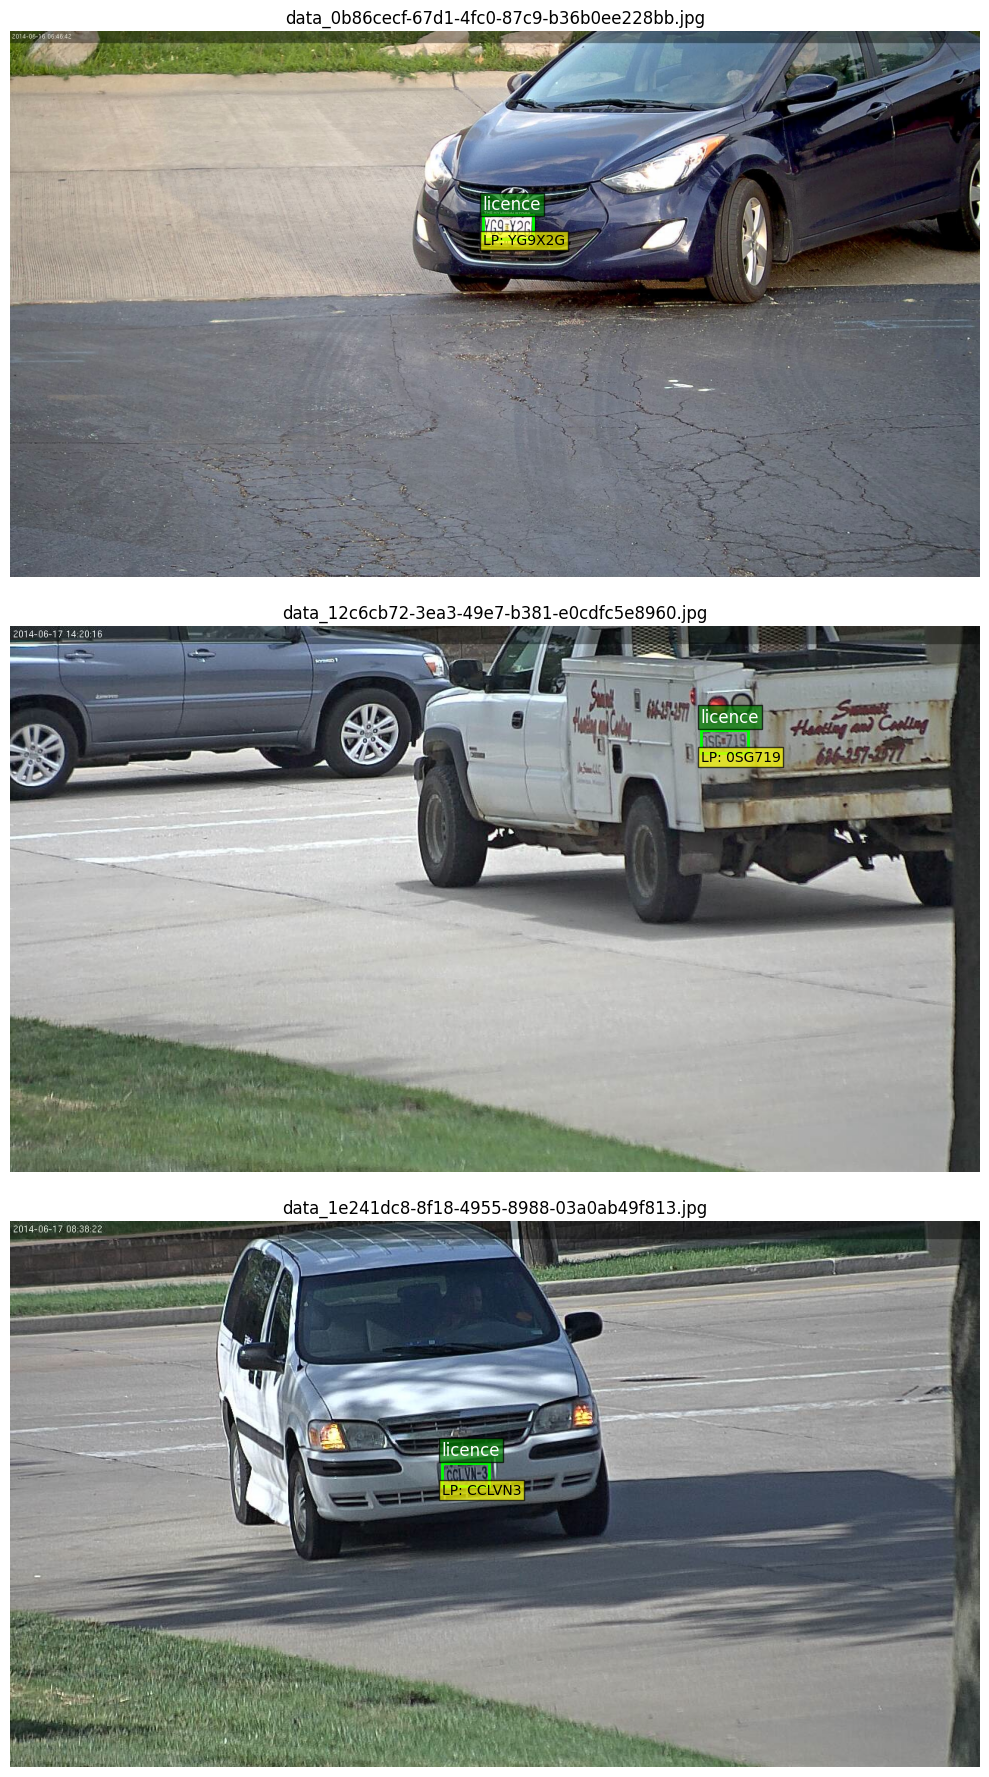

In [6]:
def visualize_image_with_bbox(img_path, xml_path, ax=None):
    """Visualize an image with its bounding box from XML"""
    # Parse XML
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        # Load image
        img = cv2.imread(img_path)
        if img is None:
            print(f"Could not read image: {img_path}")
            return False
        
        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Create axes if not provided
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 8))
        
        # Show image
        ax.imshow(img)
        
        # Get objects
        for obj in root.findall('.//object'):
            name_elem = obj.find('n')
            name = name_elem.text if name_elem is not None else "license"
            
            bbox = obj.find('bndbox')
            if bbox is None:
                continue
                
            # Get coordinates
            xmin = int(float(bbox.find('xmin').text))
            ymin = int(float(bbox.find('ymin').text))
            xmax = int(float(bbox.find('xmax').text))
            ymax = int(float(bbox.find('ymax').text))
            
            # Draw rectangle
            width = xmax - xmin
            height = ymax - ymin
            rect = plt.Rectangle((xmin, ymin), width, height,
                               fill=False, edgecolor='lime', linewidth=2)
            ax.add_patch(rect)
            
            # Add label
            ax.text(xmin, ymin-10, name, fontsize=12, color='white',
                   bbox=dict(facecolor='green', alpha=0.7, pad=2))
            
            # Add license text if available
            license_text_elem = obj.find('license_text')
            if license_text_elem is not None and license_text_elem.text:
                ax.text(xmin, ymax+10, f"LP: {license_text_elem.text}", 
                       fontsize=10, color='black',
                       bbox=dict(facecolor='yellow', alpha=0.7, pad=2))
        
        ax.set_title(os.path.basename(img_path))
        ax.axis('off')
        
        return True
    except Exception as e:
        print(f"Error visualizing {img_path} with {xml_path}: {e}")
        return False

# Visualize some samples from the converted dataset
data_samples = [f for f in os.listdir(output_anno_dir) if f.startswith('data_')][:3]

if data_samples:
    fig, axes = plt.subplots(len(data_samples), 1, figsize=(10, 6*len(data_samples)))
    
    if len(data_samples) == 1:
        axes = [axes]
    
    for i, xml_file in enumerate(data_samples):
        # Get corresponding image file
        basename = os.path.splitext(xml_file)[0]
        
        # Find matching image
        img_files = [f for f in os.listdir(output_images_dir) 
                     if f.startswith(basename) and f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        if img_files:
            img_path = os.path.join(output_images_dir, img_files[0])
            xml_path = os.path.join(output_anno_dir, xml_file)
            
            success = visualize_image_with_bbox(img_path, xml_path, ax=axes[i])
            if not success:
                axes[i].text(0.5, 0.5, f"Error loading {img_files[0]}",
                           ha='center', va='center', fontsize=12)
        else:
            axes[i].text(0.5, 0.5, f"No matching image for {xml_file}",
                       ha='center', va='center', fontsize=12)
    
    plt.tight_layout()
    plt.show()
else:
    print("No samples found for visualization")

## Summary

We've successfully converted the license plate annotations from TXT format to XML format and integrated them into the Dataset_XML structure. The conversion process:

1. Converted coordinate system from (x, y, w, h) to (xmin, ymin, xmax, ymax)
2. Created proper XML structure matching the existing Dataset_XML format
3. Preserved the license plate text information where available
4. Added a prefix "data_" to avoid filename conflicts with existing datasets

All converted files are now available in the Dataset_XML directory with the same structure as the previously combined DataV2 and DataV3 datasets.

### Dataset_XML now contains:
- DataV2 images with prefix "v2_"
- DataV3 images with prefix "v3_"
- Data images with prefix "data_"

This unified dataset can now be used for training and evaluation of license plate detection models.